In [114]:
from matplotlib import pyplot as plt
import numpy as np


def rk4(h, y, inputs, f):
    '''
    用于数值积分的rk4函数。
    args:
        h - 步长
        y - 当前状态量
        inputs - 外界对系统的输入
        f - 常微分或偏微分方程
    return:
        y_new - 新的状态量,即经过h时间之后的状态量
    '''
    k1 = f(y, inputs)
    k2 = f(y + h / 2 * k1, inputs)
    k3 = f(y + h / 2 * k2, inputs)
    k4 = f(y + h * k3, inputs)

    y_new = y + h / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
    return y_new


def sigmoid(x):
    return 2 * (1 / (1 + np.exp(-(np.array(x)))) - 0.5)


reluoffset = .13
def relu(x, reluoffset=reluoffset):  
    return np.maximum(0, np.array(x)-reluoffset)  


def myplot(t, listarray, label, linestyle='-'):
    plt.plot(t,listarray, label=label, linestyle=linestyle)
    plt.legend()


class LowPassFilter:
    """
    current输入当前膜电位,
    history是current历史轨迹,注意历史轨迹初值应该等于当前,
    derivative()是history动力学方程,
    step()返回history,
    update()更新current,
    """
    def __init__(self, current=None, history=None, tau=0.1, dt=1) -> None:
        if current is not None:
            self.current = current
        else:
            assert current is not None, "The current is None."
        if history is None:            
            self.history = current
        else:
            self.history = history
        self.tau = tau
        self.dt = dt
        self.currentnew = self.current
        self.historynew = self.history
    
    def derivative(self, state, inputs=0):
        history = state
        Dhistory = self.tau * (self.current - history)
        return Dhistory

    def step(self, dt, current, inputs=0 ):
        """
        返回新的历史轨迹
        """
        if dt is None:
            dt = self.dt
        state = self.history
        self.current = current
        statenew = rk4(dt, state, inputs, self.derivative)
        self.historynew = statenew
        self.currentnew = self.current
        return statenew

    def update(self):
        self.current = self.currentnew
        self.history = self.historynew    


class Neuron:
    def __init__(self, num=3, I=0, potential=None, trajectory=None, tau=0.1, dt=1) -> None:
        """
        根据输入I,获取神经元激活的兴奋程度potential(兴奋当前1),
        trajectory(兴奋历史2)是potential的历史兴奋程度,
        delta(兴奋增量3)是兴奋当前-兴奋历史(1-2),
        updateDelta()更新delta,
        ,
        """
        self.num = num
        self.I = I
        assert self.num == np.size(I), "The input size is different from the neuron number."
        if potential is None:
            self.potential = self.activation(I)
        else:
            self.potential = potential
        if trajectory is None:
            self.trajectory = self.potential
        self.potentialnew = self.potential
        self.trajectorynew = self.trajectory
        self.delta = self.potential - self.trajectory        
        self.tau = tau
        self.dt = dt
        self.lowpassfilter = LowPassFilter(self.potential, self.trajectory, self.tau, self.dt)
    
    def updateDelta(self):
        self.delta = self.potential - self.trajectory 
        return self.delta
    
    def activation(self, I):
        return sigmoid(I)    
    """
    # def step(self, dt, inputs=0):
    #     if dt is None:
    #         dt = self.dt
    #     state = self.history
    #     statenew = rk4(dt, state, inputs, self.derivative)
    #     self.history = statenew
    #     return statenew
    """
    def step(self, dt, I):
        if dt is None:
            dt = self.dt
        assert self.num == np.size(I), "The input size is different from the neuron number."
        self.potential = self.activation(I)
        self.trajectory = self.potential
        self.trajectorynew = self.lowpassfilter.step(dt=dt, current=self.potential)
        self.potentialnew = self.potential
        return self.trajectorynew

    def update(self):
        self.potential = self.potentialnew
        self.trajectory = self.trajectorynew
        self.updateDelta()
        self.lowpassfilter.update()


class Synapse:
    def __init__(self, preNeuron: Neuron, postNeuron: Neuron, weight=None, reward=0, alpha=1, beta=1, dt=1, tau=1,) -> None:
        self.preNeuron = preNeuron
        self.postNeuron = postNeuron
        self.preNum = self.preNeuron.num
        self.postNum = self.postNeuron.num
        self.preI = self.preNeuron.I
        self.postI = self.postNeuron.I
        self.prePotential = self.preNeuron.potential
        self.prePotentialnew = self.prePotential
        self.preTrajectory = self.prePotential  # self.preNeuron.trajectory
        self.preTrajectorynew = self.preTrajectory
        self.postPotential = self.postNeuron.potential
        self.postPotentialnew = self.postPotential
        self.postTrajectory = self.postPotential  # self.preNeuron.trajectory
        self.postTrajectorynew = self.postTrajectory
        if weight is not None:
            self.weight = weight
        else:
            assert weight is not None, "The weight is None."
        assert self.weight.shape == (self.postNum, self.preNum), "The shape of the weight does not match. "
        self.reward = np.array(reward)
        self.alpha = alpha
        self.beta = beta
        self.dt = dt
        self.tau = tau

    def derivative(self, state, inputs=0):
        w = state
        # Dw = (np.matmul(self.beta * np.tile(self.postTrajectory, self.postNum), (self.alpha * self.preTrajectory.T - w)) * self.reward) / self.tau
        Dw = self.beta * ( self.postTrajectory * self.reward * (self.alpha * self.preTrajectory.T - w))  / self.tau
        return Dw

    def step(self, dt, preI, postI=None, inputs=0):
        self.preI = preI
        if dt is None:
            dt = self.dt
        state = self.weight
        statenew = rk4(dt, state, inputs, self.derivative)
        self.weight = statenew
        self.preTrajectorynew = self.preNeuron.step(dt, self.preI)
        # self.postI = np.matmul(self.weight, self.prePotential)
        if postI is None:
            self.postI = np.matmul(self.weight, self.preNeuron.activation(self.preI))
        else:
            self.postI = postI
        self.postTrajectorynew = self.postNeuron.step(dt, self.postI)
        return statenew

    def update(self):
        self.prePotential = self.preNeuron.potential
        self.preTrajectory = self.preTrajectorynew
        self.postPotential = self.postNeuron.potential
        self.postTrajectory = self.postTrajectorynew
        # self.preNeuron.potential = self.prePotentialnew
        # self.postNeuron.potential = self.postPotential
        self.preNeuron.update()
        self.postNeuron.update()  
        

class SynapseKM(Synapse):
    def __init__(self, preNeuron: Neuron, postNeuron: Neuron, weight=None, reward=0, alpha=1, beta=1, dt=1, tau=1) -> None:
        super().__init__(preNeuron, postNeuron, weight, reward, alpha, beta, dt, tau)
    
    def derivative(self, state, inputs=0):
        return super().derivative(state, inputs)

    def step(self, dt, preI, postI=None, inputs=0):
        return super().step(dt, preI, postI, inputs)
    
    def update(self):
        return super().update()
    

class SynapseKD(Synapse):
    def __init__(self, preNeuron: Neuron, postNeuron: Neuron, weight=None, reward=0, alpha=1, beta=1, dt=1, tau=1) -> None:
        super().__init__(preNeuron, postNeuron, weight, reward, alpha, beta, dt, tau)
        self.delta = self.preNeuron.delta
    
    def derivative(self, state, inputs=0):
        w = state
        delta = self.delta
        # Dw = (np.matmul(self.beta * np.tile(self.postPotential, self.postNum), (self.alpha * delta.T - w)) * self.reward) / self.tau
        Dw = self.beta * (self.postPotential * self.reward * (self.alpha * delta.T - w)) / self.tau
        return Dw

    def step(self, dt, preI, postI=None, inputs=0):
        return super().step(dt, preI, postI, inputs)
    
    def update(self):
        self.preNeuron.trajectory = self.preTrajectorynew
        self.delta = self.preNeuron.updateDelta()
        return super().update()
    
        
class SynapseDK(Synapse):
    def __init__(self, preNeuron: Neuron, postNeuron: Neuron, weight=None, reward=0, alpha=1, beta=1, dt=1, tau=1) -> None:
        super().__init__(preNeuron, postNeuron, weight, reward, alpha, beta, dt, tau)
        self.delta = self.postNeuron.delta

    def derivative(self, state, inputs=0):
        w = state
        delta = self.delta
        # Dw = (np.matmul(self.beta * np.tile(delta, self.postNum), (self.alpha * self.preTrajectory.T - w)) * self.reward) / self.tau
        # print(delta.shape, self.reward.shape, self.preTrajectory.T.shape, w.shape)
        Dw = self.beta * (delta * self.reward * (self.alpha * self.preTrajectory.T - w)) / self.tau
        return Dw
    
    def step(self, dt, preI, postI=None, inputs=0):
        return super().step(dt, preI, postI, inputs)
    
    def update(self):
        self.postNeuron.trajectory = self.postTrajectorynew
        self.delta = self.postNeuron.updateDelta()
        return super().update()        


numKC, numMBON, numDAN = 6, 3, 3
stepNum = 15000*5
start = 0
dt = .02
end = start + stepNum * dt
t = np.linspace(start, end, stepNum)
print(f"start:{start}, end:{end}, dt:{dt}, stepNum:{stepNum}")

start:0, end:1500.0, dt:0.02, stepNum:75000


## 4.15

### dan+lowpass

In [ ]:
"""
1. 初始化DK权重
2. 初始化dan电流
3. 计算得potential = sDK * idan
4. 将potential加入到KCI 
"""
WeightDK = np.array([[0,0,1],[0,0,1],[1,0,0],[1,0,0],[0,1,0],[0,1,0]])
IDAN = np.array([0,0,0]).reshape(numDAN,1)
IDANactivateKC = np.matmul(WeightDK, IDAN)

# 测试KM收敛
initWeightKM = np.zeros([numMBON,numKC])
IKC = np.array([1,1,0,0,0,0], dtype=np.float64).reshape(numKC,1)
KC = Neuron(numKC, IKC, dt=dt,tau=0.003)
IMBON = np.array([1,0,0]).reshape(numMBON,1)
MBON = Neuron(numMBON, IMBON, dt=dt,tau=0.02)
skmreward = np.array([0,0,0]).reshape(numDAN,1)
# reward = 1
skm = SynapseKM(KC, MBON, initWeightKM, reward=skmreward,dt=dt,tau=10)

skmweight=[]
KCp,KCt,DANp,DANt,MBONp,MBONt = [],[],[],[],[],[]
KCI,DANI,MBONI = [],[],[]
skmrewardI = []
DANactivateKCI, DANactivateKCItra = [], []
lenterm = end/3

DANLPF = LowPassFilter(current=IDANactivateKC)

for i in t:
    if i < lenterm:
        IKC = np.array([1,1,0,0,0,0], dtype=np.float64).reshape(numKC,1)
        IMBON = np.array([1,0,0]).reshape(numMBON,1)
    elif lenterm <= i < lenterm * 2:
        IKC = np.array([0,0,1,1,0,0], dtype=np.float64).reshape(numKC,1)
        IMBON = np.array([0,1,0]).reshape(numMBON,1)
    else:
        IKC = np.array([0,0,0,0,1,1], dtype=np.float64).reshape(numKC,1)
        IMBON = np.array([0,0,1]).reshape(numMBON,1)
        
    if lenterm * .8 < i < lenterm:
        skmreward = np.array([1,0,0]).reshape(numDAN,1)
        IDAN = np.array([0,0,1]).reshape(numDAN,1)
        # IKC = np.array([1 - (i - lenterm * .8)/100,1 - (i - lenterm * .8)/100,(i - lenterm * .8)/100,(i - lenterm * .8)/100,0,0]).reshape(numKC,1)
    elif lenterm * 1.8 < i < lenterm * 2:
        skmreward = np.array([0,1,0]).reshape(numDAN,1)
        IDAN = np.array([1,0,0]).reshape(numDAN,1)
        # IKC = np.array([0,0,1 - (i - lenterm * 1.8)/100,1 - (i - lenterm * 1.8)/100,(i - lenterm * 1.8)/100,(i - lenterm * 1.8)/100]).reshape(numKC,1)
    elif lenterm * 2.8 < i < lenterm * 3:
        skmreward = np.array([0,0,1]).reshape(numDAN,1)        
        IDAN = np.array([0,1,0]).reshape(numDAN,1)
        # IKC = np.array([(i - lenterm * 2.8)/100,(i - lenterm * 2.8)/100,0,0,1 - (i - lenterm * 2.8)/100,1 - (i - lenterm * 2.8)/100]).reshape(numKC,1)
    else:
        skmreward = np.array([0,0,0]).reshape(numDAN,1)
        IDAN = np.array([0,0,0]).reshape(numDAN,1)
          
    IDANactivateKC = np.matmul(WeightDK, IDAN)
    
    DANactivateKCI.append(DANLPF.current)
    IDANactivateKCtra = DANLPF.step(dt=dt, current=IDANactivateKC)
    DANactivateKCItra.append(DANLPF.history)
    DANLPF.update()
    # print(IKC.dtype,IDANactivateKCtra.dtype)
    IKC += IDANactivateKCtra
    skm.reward = skmreward
    skmrewardI.append(skmreward)
    DANI.append(IDAN)    
    KCI.append(skm.preI)
    MBONI.append(skm.postI)
    KCp.append(skm.prePotential)
    KCt.append(skm.preTrajectory)
    MBONp.append(skm.postPotential)
    MBONt.append(skm.postTrajectory)
    
    # print(skm.preTrajectory)
    KMWeight = skm.step(dt,IKC,IMBON)
    skm.update()
    skmweight.append(KMWeight)

# 画DANI
DANI = np.array(DANI)
for i in range(numDAN):
    plt.subplot(numDAN,1,i+1)
    myplot(t, DANI[:,i,0], label='DANI'+str(i))
plt.show()

# 画danpotential
DANactivateKCI = np.array(DANactivateKCI)
DANactivateKCItra = np.array(DANactivateKCItra)
for i in range(numKC):
    plt.subplot(numKC,1,i+1)
    myplot(t,DANactivateKCI[:,i,0], label='DANpKCI'+str(i))
    myplot(t,DANactivateKCItra[:,i,0], label='DANpKCIt'+str(i))
plt.show()

# linstylelist = ['-',':','-.','--']
# plt.figure()
# 画KC
KCI = np.array(KCI)
KCp = np.array(KCp)
KCt = np.array(KCt)
for i in range(numKC):
    plt.subplot(numKC,1,i+1)
    myplot(t,KCI[:,i,0],label='KCI'+str(i),)
    myplot(t,KCp[:,i,0],label='KCp'+str(i),linestyle='--')
    myplot(t,KCt[:,i,0],label='KCt'+str(i),linestyle=':')
plt.show()

# 画MBON
MBONI = np.array(MBONI)
MBONp = np.array(MBONp)
MBONt = np.array(MBONt)
for i in range(numMBON):
    plt.subplot(numMBON,1,i+1)
    myplot(t,MBONI[:,i,0],label='MBONI'+str(i)) 
    myplot(t,MBONp[:,i,0],label='MBONp'+str(i))   
    myplot(t,MBONt[:,i,0],label='MBONt'+str(i))   
plt.show() 

# 画reward
skmrewardI = np.array(skmrewardI)
for i in range(numDAN):
    plt.subplot(numDAN,1,i+1)
    myplot(t, skmrewardI[:,i,0], label='rewardI'+str(i))
plt.show()

# 画权重
skmweight = np.array(skmweight)
cur_figsize = plt.gcf().get_size_inches()
plt.figure(figsize=(cur_figsize[0] * 3, cur_figsize[1] * 1.5))
for j in range(numMBON):
    for i in range(numKC):
        plt.subplot(numMBON,numKC,j*numKC+i+1)     
        myplot(t,skmweight[:,j,i],label='skm'+str(j)+str(i))
plt.show()

ylimlow, ylimhigh = 0, 1

for i in range(numKC):
    plt.subplot(numKC,1,i+1)
    plt.ylim(ylimlow,ylimhigh)
    myplot(t,skmweight[:,0,i],label='skm'+str(0)+str(i))
plt.show()

for i in range(numKC):
    plt.subplot(numKC,1,i+1)
    plt.ylim(ylimlow,ylimhigh)
    myplot(t,skmweight[:,1,i],label='skm'+str(1)+str(i))
plt.show()

for i in range(numKC):
    plt.subplot(numKC,1,i+1)
    plt.ylim(ylimlow,ylimhigh)
    myplot(t,skmweight[:,2,i],label='skm'+str(2)+str(i))
plt.show()

In [ ]:
res = stepNum/3 
res*.8
skmweight[25000,0,0],skmweight[50000,1,1],skmweight[74999,2,3]

### sigmoid+relu

In [ ]:
# 2.a 不加offset
"""
1. 初始化DK权重
2. 初始化dan电流
3. 计算得potential = sDK * idan
4. 将potential加入到KCI 
"""
WeightDK = np.array([[0,0,1],[0,0,1],[1,0,0],[1,0,0],[0,1,0],[0,1,0]])
IDAN = np.array([0,0,0]).reshape(numDAN,1)
IDANactivateKC = np.matmul(WeightDK, IDAN)

# 测试KM收敛
initWeightKM = np.zeros([numMBON,numKC])
IKC = np.array([1,1,0,0,0,0], dtype=np.float64).reshape(numKC,1)
KC = Neuron(numKC, IKC, dt=dt,tau=0.003)
IMBON = np.array([1,0,0]).reshape(numMBON,1)
MBON = Neuron(numMBON, IMBON, dt=dt,tau=0.02)
skmreward = np.array([0,0,0]).reshape(numDAN,1)
# reward = 1
skm = SynapseKM(KC, MBON, initWeightKM, reward=skmreward,dt=dt,tau=10)

skmweight=[]
KCp,KCt,DANp,DANt,MBONp,MBONt = [],[],[],[],[],[]
KCI,DANI,MBONI = [],[],[]
skmrewardI = []
DANactivateKCI, DANactivateKCItra = [], []
lenterm = end/3

DANLPF = LowPassFilter(current=IDANactivateKC)

for i in t:
    if i < lenterm:
        IKC = np.array([1,1,0,0,0,0], dtype=np.float64).reshape(numKC,1)
        IMBON = np.array([1,0,0]).reshape(numMBON,1)
    elif lenterm <= i < lenterm * 2:
        IKC = np.array([0,0,1,1,0,0], dtype=np.float64).reshape(numKC,1)
        IMBON = np.array([0,1,0]).reshape(numMBON,1)
    else:
        IKC = np.array([0,0,0,0,1,1], dtype=np.float64).reshape(numKC,1)
        IMBON = np.array([0,0,1]).reshape(numMBON,1)
        
    if lenterm * .8 < i < lenterm:
        skmreward = np.array([1,0,0]).reshape(numDAN,1)
        IDAN = np.array([0,0,1]).reshape(numDAN,1)
        # IKC = np.array([1 - (i - lenterm * .8)/100,1 - (i - lenterm * .8)/100,(i - lenterm * .8)/100,(i - lenterm * .8)/100,0,0]).reshape(numKC,1)
    elif lenterm * 1.8 < i < lenterm * 2:
        skmreward = np.array([0,1,0]).reshape(numDAN,1)
        IDAN = np.array([1,0,0]).reshape(numDAN,1)
        # IKC = np.array([0,0,1 - (i - lenterm * 1.8)/100,1 - (i - lenterm * 1.8)/100,(i - lenterm * 1.8)/100,(i - lenterm * 1.8)/100]).reshape(numKC,1)
    elif lenterm * 2.8 < i < lenterm * 3:
        skmreward = np.array([0,0,1]).reshape(numDAN,1)        
        IDAN = np.array([0,1,0]).reshape(numDAN,1)
        # IKC = np.array([(i - lenterm * 2.8)/100,(i - lenterm * 2.8)/100,0,0,1 - (i - lenterm * 2.8)/100,1 - (i - lenterm * 2.8)/100]).reshape(numKC,1)
    else:
        skmreward = np.array([0,0,0]).reshape(numDAN,1)
        IDAN = np.array([0,0,0]).reshape(numDAN,1)
          
    IDANactivateKC = np.matmul(WeightDK, IDAN)
    
    DANactivateKCI.append(DANLPF.current)
    IDANactivateKCtra = DANLPF.step(dt=dt, current=IDANactivateKC)
    DANactivateKCItra.append(DANLPF.history)
    DANLPF.update()
    # print(IKC.dtype,IDANactivateKCtra.dtype)
    IKC += IDANactivateKCtra
    skm.reward = skmreward
    skmrewardI.append(skmreward)
    DANI.append(IDAN)    
    KCI.append(skm.preI)
    MBONI.append(skm.postI)
    KCp.append(skm.prePotential)
    KCt.append(skm.preTrajectory)
    MBONp.append(skm.postPotential)
    MBONt.append(skm.postTrajectory)
    
    # print(skm.preTrajectory)
    KMWeight = skm.step(dt,IKC,IMBON)
    skm.update()
    skmweight.append(KMWeight)

# 画DANI
DANI = np.array(DANI)
for i in range(numDAN):
    plt.subplot(numDAN,1,i+1)
    myplot(t, DANI[:,i,0], label='DANI'+str(i))
plt.show()

# 画danpotential
DANactivateKCI = np.array(DANactivateKCI)
DANactivateKCItra = np.array(DANactivateKCItra)
for i in range(numKC):
    plt.subplot(numKC,1,i+1)
    myplot(t,DANactivateKCI[:,i,0], label='DANpKCI'+str(i))
    myplot(t,DANactivateKCItra[:,i,0], label='DANpKCIt'+str(i))
plt.show()

# linstylelist = ['-',':','-.','--']
# plt.figure()
# 画KC
KCI = np.array(KCI)
KCp = np.array(KCp)
# KCt = np.array(KCt)
KCt = relu(KCt)
for i in range(numKC):
    plt.subplot(numKC,1,i+1)
    myplot(t,KCI[:,i,0],label='KCI'+str(i),)
    myplot(t,KCp[:,i,0],label='KCp'+str(i),linestyle='--')
    myplot(t,KCt[:,i,0],label='KCt'+str(i),linestyle=':')
plt.show()

# 画MBON
MBONI = np.array(MBONI)
MBONp = np.array(MBONp)
MBONt = np.array(MBONt)
for i in range(numMBON):
    plt.subplot(numMBON,1,i+1)
    myplot(t,MBONI[:,i,0],label='MBONI'+str(i)) 
    myplot(t,MBONp[:,i,0],label='MBONp'+str(i))   
    myplot(t,MBONt[:,i,0],label='MBONt'+str(i))   
plt.show() 

# 画reward
skmrewardI = np.array(skmrewardI)
for i in range(numDAN):
    plt.subplot(numDAN,1,i+1)
    myplot(t, skmrewardI[:,i,0], label='rewardI'+str(i))
plt.show()

# 画权重
skmweight = np.array(skmweight)
cur_figsize = plt.gcf().get_size_inches()
plt.figure(figsize=(cur_figsize[0] * 3, cur_figsize[1] * 1.5))
for j in range(numMBON):
    for i in range(numKC):
        plt.subplot(numMBON,numKC,j*numKC+i+1)     
        myplot(t,skmweight[:,j,i],label='skm'+str(j)+str(i))
plt.show()

ylimlow, ylimhigh = 0, 1
skmweight = relu(skmweight)
for i in range(numKC):
    plt.subplot(numKC,1,i+1)
    plt.ylim(ylimlow,ylimhigh)
    myplot(t,skmweight[:,0,i],label='skm'+str(0)+str(i))
plt.show()

for i in range(numKC):
    plt.subplot(numKC,1,i+1)
    plt.ylim(ylimlow,ylimhigh)
    myplot(t,skmweight[:,1,i],label='skm'+str(1)+str(i))
plt.show()

for i in range(numKC):
    plt.subplot(numKC,1,i+1)
    plt.ylim(ylimlow,ylimhigh)
    myplot(t,skmweight[:,2,i],label='skm'+str(2)+str(i))
plt.show()

In [ ]:
# 2.b 加上offset
reluoffset = .13
def relu(x):  
    res = np.maximum(0, np.array(x)-reluoffset)
    res[res>0] += reluoffset
    return res
"""
1. 初始化DK权重
2. 初始化dan电流
3. 计算得potential = sDK * idan
4. 将potential加入到KCI 
"""
WeightDK = np.array([[0,0,1],[0,0,1],[1,0,0],[1,0,0],[0,1,0],[0,1,0]])
IDAN = np.array([0,0,0]).reshape(numDAN,1)
IDANactivateKC = np.matmul(WeightDK, IDAN)

# 测试KM收敛
initWeightKM = np.zeros([numMBON,numKC])
IKC = np.array([1,1,0,0,0,0], dtype=np.float64).reshape(numKC,1)
KC = Neuron(numKC, IKC, dt=dt,tau=0.003)
IMBON = np.array([1,0,0]).reshape(numMBON,1)
MBON = Neuron(numMBON, IMBON, dt=dt,tau=0.02)
skmreward = np.array([0,0,0]).reshape(numDAN,1)
# reward = 1
skm = SynapseKM(KC, MBON, initWeightKM, reward=skmreward,dt=dt,tau=10)

skmweight=[]
KCp,KCt,DANp,DANt,MBONp,MBONt = [],[],[],[],[],[]
KCI,DANI,MBONI = [],[],[]
skmrewardI = []
DANactivateKCI, DANactivateKCItra = [], []
lenterm = end/3

DANLPF = LowPassFilter(current=IDANactivateKC)

for i in t:
    if i < lenterm:
        IKC = np.array([1,1,0,0,0,0], dtype=np.float64).reshape(numKC,1)
        IMBON = np.array([1,0,0]).reshape(numMBON,1)
    elif lenterm <= i < lenterm * 2:
        IKC = np.array([0,0,1,1,0,0], dtype=np.float64).reshape(numKC,1)
        IMBON = np.array([0,1,0]).reshape(numMBON,1)
    else:
        IKC = np.array([0,0,0,0,1,1], dtype=np.float64).reshape(numKC,1)
        IMBON = np.array([0,0,1]).reshape(numMBON,1)
        
    if lenterm * .8 < i < lenterm:
        skmreward = np.array([1,0,0]).reshape(numDAN,1)
        IDAN = np.array([0,0,1]).reshape(numDAN,1)
        # IKC = np.array([1 - (i - lenterm * .8)/100,1 - (i - lenterm * .8)/100,(i - lenterm * .8)/100,(i - lenterm * .8)/100,0,0]).reshape(numKC,1)
    elif lenterm * 1.8 < i < lenterm * 2:
        skmreward = np.array([0,1,0]).reshape(numDAN,1)
        IDAN = np.array([1,0,0]).reshape(numDAN,1)
        # IKC = np.array([0,0,1 - (i - lenterm * 1.8)/100,1 - (i - lenterm * 1.8)/100,(i - lenterm * 1.8)/100,(i - lenterm * 1.8)/100]).reshape(numKC,1)
    elif lenterm * 2.8 < i < lenterm * 3:
        skmreward = np.array([0,0,1]).reshape(numDAN,1)        
        IDAN = np.array([0,1,0]).reshape(numDAN,1)
        # IKC = np.array([(i - lenterm * 2.8)/100,(i - lenterm * 2.8)/100,0,0,1 - (i - lenterm * 2.8)/100,1 - (i - lenterm * 2.8)/100]).reshape(numKC,1)
    else:
        skmreward = np.array([0,0,0]).reshape(numDAN,1)
        IDAN = np.array([0,0,0]).reshape(numDAN,1)
          
    IDANactivateKC = np.matmul(WeightDK, IDAN)
    
    DANactivateKCI.append(DANLPF.current)
    IDANactivateKCtra = DANLPF.step(dt=dt, current=IDANactivateKC)
    DANactivateKCItra.append(DANLPF.history)
    DANLPF.update()
    # print(IKC.dtype,IDANactivateKCtra.dtype)
    IKC += IDANactivateKCtra
    skm.reward = skmreward
    skmrewardI.append(skmreward)
    DANI.append(IDAN)    
    KCI.append(skm.preI)
    MBONI.append(skm.postI)
    KCp.append(skm.prePotential)
    KCt.append(skm.preTrajectory)
    MBONp.append(skm.postPotential)
    MBONt.append(skm.postTrajectory)
    
    # print(skm.preTrajectory)
    KMWeight = skm.step(dt,IKC,IMBON)
    skm.update()
    skmweight.append(KMWeight)

# 画DANI
DANI = np.array(DANI)
for i in range(numDAN):
    plt.subplot(numDAN,1,i+1)
    myplot(t, DANI[:,i,0], label='DANI'+str(i))
plt.show()

# 画danpotential
DANactivateKCI = np.array(DANactivateKCI)
DANactivateKCItra = np.array(DANactivateKCItra)
for i in range(numKC):
    plt.subplot(numKC,1,i+1)
    myplot(t,DANactivateKCI[:,i,0], label='DANpKCI'+str(i))
    myplot(t,DANactivateKCItra[:,i,0], label='DANpKCIt'+str(i))
plt.show()

# linstylelist = ['-',':','-.','--']
# plt.figure()
# 画KC
KCI = np.array(KCI)
KCp = np.array(KCp)
# KCt = np.array(KCt)
KCt = relu(KCt)
for i in range(numKC):
    plt.subplot(numKC,1,i+1)
    myplot(t,KCI[:,i,0],label='KCI'+str(i),)
    myplot(t,KCp[:,i,0],label='KCp'+str(i),linestyle='--')
    myplot(t,KCt[:,i,0],label='KCt'+str(i),linestyle=':')
plt.show()

# 画MBON
MBONI = np.array(MBONI)
MBONp = np.array(MBONp)
MBONt = np.array(MBONt)
for i in range(numMBON):
    plt.subplot(numMBON,1,i+1)
    myplot(t,MBONI[:,i,0],label='MBONI'+str(i)) 
    myplot(t,MBONp[:,i,0],label='MBONp'+str(i))   
    myplot(t,MBONt[:,i,0],label='MBONt'+str(i))   
plt.show() 

# 画reward
skmrewardI = np.array(skmrewardI)
for i in range(numDAN):
    plt.subplot(numDAN,1,i+1)
    myplot(t, skmrewardI[:,i,0], label='rewardI'+str(i))
plt.show()

# 画权重
skmweight = np.array(skmweight)
cur_figsize = plt.gcf().get_size_inches()
plt.figure(figsize=(cur_figsize[0] * 3, cur_figsize[1] * 1.5))
for j in range(numMBON):
    for i in range(numKC):
        plt.subplot(numMBON,numKC,j*numKC+i+1)     
        myplot(t,skmweight[:,j,i],label='skm'+str(j)+str(i))
plt.show()

ylimlow, ylimhigh = 0, 1
skmweight = relu(skmweight)
for i in range(numKC):
    plt.subplot(numKC,1,i+1)
    plt.ylim(ylimlow,ylimhigh)
    myplot(t,skmweight[:,0,i],label='skm'+str(0)+str(i))
plt.show()

for i in range(numKC):
    plt.subplot(numKC,1,i+1)
    plt.ylim(ylimlow,ylimhigh)
    myplot(t,skmweight[:,1,i],label='skm'+str(1)+str(i))
plt.show()

for i in range(numKC):
    plt.subplot(numKC,1,i+1)
    plt.ylim(ylimlow,ylimhigh)
    myplot(t,skmweight[:,2,i],label='skm'+str(2)+str(i))
plt.show()

## 4.17

### DAN预激活+sensor是否有效

In [ ]:
reluoffset = .33

WeightDK = np.array([[1,0,0],[1,0,0],[0,1,0],[0,1,0],[0,0,1],[0,0,1]])
IDAN = np.array([0,0,0]).reshape(numDAN,1)
IDANactivateKC = np.matmul(WeightDK, IDAN)

# 测试KM收敛
initWeightKM = np.zeros([numMBON,numKC])
IKC = np.array([1,1,0,0,0,0], dtype=np.float64).reshape(numKC,1)
KC = Neuron(numKC, IKC, dt=dt,tau=0.003)
IMBON = np.array([1,0,0]).reshape(numMBON,1)
MBON = Neuron(numMBON, IMBON, dt=dt,tau=0.02)
skmreward = np.array([0,0,0]).reshape(numDAN,1)
# reward = 1
skm = SynapseKM(KC, MBON, initWeightKM, reward=skmreward,dt=dt,tau=5)

skmweight=[]
KCp,KCt,DANp,DANt,MBONp,MBONt = [],[],[],[],[],[]
KCI,DANI,MBONI = [],[],[]
skmrewardI = []
DANactivateKCI, DANactivateKCItra = [], []
lenterm = end/3

DANLPF = LowPassFilter(current=IDANactivateKC)

for i in t:
    if i < lenterm:
        IKC = np.array([1,1,0,0,0,0], dtype=np.float64).reshape(numKC,1)
        IMBON = np.array([1,0,0]).reshape(numMBON,1)
    elif lenterm <= i < lenterm * 2:
        IKC = np.array([0,0,1,1,0,0], dtype=np.float64).reshape(numKC,1)
        IMBON = np.array([0,1,0]).reshape(numMBON,1)
    else:
        IKC = np.array([0,0,0,0,1,1], dtype=np.float64).reshape(numKC,1)
        IMBON = np.array([0,0,1]).reshape(numMBON,1)
        
    if lenterm * .8 < i < lenterm:
        skmreward = np.array([1,0,0]).reshape(numDAN,1)
        IDAN = np.array([1,0,0]).reshape(numDAN,1)
        # IKC = np.array([1 - (i - lenterm * .8)/100,1 - (i - lenterm * .8)/100,(i - lenterm * .8)/100,(i - lenterm * .8)/100,0,0]).reshape(numKC,1)
    elif lenterm * 1.8 < i < lenterm * 2:
        skmreward = np.array([0,1,0]).reshape(numDAN,1)
        IDAN = np.array([0,1,0]).reshape(numDAN,1)
        # IKC = np.array([0,0,1 - (i - lenterm * 1.8)/100,1 - (i - lenterm * 1.8)/100,(i - lenterm * 1.8)/100,(i - lenterm * 1.8)/100]).reshape(numKC,1)
    elif lenterm * 2.8 < i < lenterm * 3:
        skmreward = np.array([0,0,1]).reshape(numDAN,1)        
        IDAN = np.array([0,0,1]).reshape(numDAN,1)
        # IKC = np.array([(i - lenterm * 2.8)/100,(i - lenterm * 2.8)/100,0,0,1 - (i - lenterm * 2.8)/100,1 - (i - lenterm * 2.8)/100]).reshape(numKC,1)
    else:
        skmreward = np.array([0,0,0]).reshape(numDAN,1)
        IDAN = np.array([0,0,0]).reshape(numDAN,1)
          
    IDANactivateKC = np.matmul(WeightDK, IDAN)
    
    DANactivateKCI.append(DANLPF.current)
    IDANactivateKCtra = DANLPF.step(dt=dt, current=IDANactivateKC)
    DANactivateKCItra.append(DANLPF.history)
    DANLPF.update()
    # print(IKC.dtype,IDANactivateKCtra.dtype)
    IKC += IDANactivateKCtra
    skm.reward = skmreward
    skmrewardI.append(skmreward)
    DANI.append(IDAN)    
    KCI.append(skm.preI)
    MBONI.append(skm.postI)
    KCp.append(skm.prePotential)
    KCt.append(skm.preTrajectory)
    MBONp.append(skm.postPotential)
    MBONt.append(skm.postTrajectory)
    
    # print(skm.preTrajectory)
    KMWeight = skm.step(dt,IKC,IMBON)
    skm.update()
    skmweight.append(KMWeight)

# 画DANI
# DANI = np.array(DANI)
# for i in range(numDAN):
#     plt.subplot(numDAN,1,i+1)
#     myplot(t, DANI[:,i,0], label='DANI'+str(i))
# plt.show()

# 画danpotential
# DANactivateKCI = np.array(DANactivateKCI)
# DANactivateKCItra = np.array(DANactivateKCItra)
# for i in range(numKC):
#     plt.subplot(numKC,1,i+1)
#     myplot(t,DANactivateKCI[:,i,0], label='DANpKCI'+str(i))
#     myplot(t,DANactivateKCItra[:,i,0], label='DANpKCIt'+str(i))
# plt.show()

# linstylelist = ['-',':','-.','--']
# plt.figure()
# 画KC
KCI = np.array(KCI)
KCp = np.array(KCp)
# KCt = np.array(KCt)
KCt = relu(KCt,reluoffset)
for i in range(numKC):
    plt.subplot(numKC,1,i+1)
    myplot(t,KCI[:,i,0],label='KCI'+str(i),)
    myplot(t,KCp[:,i,0],label='KCp'+str(i),linestyle='--')
    myplot(t,KCt[:,i,0],label='KCt'+str(i),linestyle=':')
plt.show()

# 画MBON
# MBONI = np.array(MBONI)
# MBONp = np.array(MBONp)
# MBONt = np.array(MBONt)
# for i in range(numMBON):
#     plt.subplot(numMBON,1,i+1)
#     myplot(t,MBONI[:,i,0],label='MBONI'+str(i)) 
#     myplot(t,MBONp[:,i,0],label='MBONp'+str(i))   
#     myplot(t,MBONt[:,i,0],label='MBONt'+str(i))   
# plt.show() 

# 画reward
# rewardI = np.array(rewardI)
# for i in range(numDAN):
#     plt.subplot(numDAN,1,i+1)
#     myplot(t, rewardI[:,i,0], label='rewardI'+str(i))
# plt.show()

# 画权重
skmweight = np.array(skmweight)
# cur_figsize = plt.gcf().get_size_inches()
# plt.figure(figsize=(cur_figsize[0] * 3, cur_figsize[1] * 1.5))
# for j in range(numMBON):
#     for i in range(numKC):
#         plt.subplot(numMBON,numKC,j*numKC+i+1)     
#         myplot(t,skmweight[:,j,i],label='skm'+str(j)+str(i))
# plt.show()

ylimlow, ylimhigh = 0, .5
skmweight = relu(skmweight,reluoffset)
for i in range(numKC):
    plt.subplot(numKC,1,i+1)
    plt.ylim(ylimlow,ylimhigh)
    myplot(t,skmweight[:,0,i],label='skm'+str(0)+str(i))
plt.show()

for i in range(numKC):
    plt.subplot(numKC,1,i+1)
    plt.ylim(ylimlow,ylimhigh)
    myplot(t,skmweight[:,1,i],label='skm'+str(1)+str(i))
plt.show()

for i in range(numKC):
    plt.subplot(numKC,1,i+1)
    plt.ylim(ylimlow,ylimhigh)
    myplot(t,skmweight[:,2,i],label='skm'+str(2)+str(i))
plt.show()

In [ ]:
reluoffset = .33
# 修改weightDK
WeightDK = np.array([[1,0,0],[0,0,0],[0,1,0],[0,0,0],[0,0,1],[0,0,0]])
IDAN = np.array([0,0,0]).reshape(numDAN,1)
IDANactivateKC = np.matmul(WeightDK, IDAN)

# 测试KM收敛
initWeightKM = np.zeros([numMBON,numKC])
IKC = np.array([1,1,0,0,0,0], dtype=np.float64).reshape(numKC,1)
KC = Neuron(numKC, IKC, dt=dt,tau=0.003)
IMBON = np.array([1,0,0]).reshape(numMBON,1)
MBON = Neuron(numMBON, IMBON, dt=dt,tau=0.02)
skmreward = np.array([0,0,0]).reshape(numDAN,1)
# reward = 1
skm = SynapseKM(KC, MBON, initWeightKM, reward=skmreward,dt=dt,tau=5)

skmweight=[]
KCp,KCt,DANp,DANt,MBONp,MBONt = [],[],[],[],[],[]
KCI,DANI,MBONI = [],[],[]
skmrewardI = []
DANactivateKCI, DANactivateKCItra = [], []
lenterm = end/3

DANLPF = LowPassFilter(current=IDANactivateKC)

for i in t:
    if i < lenterm:
        IKC = np.array([1,1,0,0,0,0], dtype=np.float64).reshape(numKC,1)
        IMBON = np.array([1,0,0]).reshape(numMBON,1)
    elif lenterm <= i < lenterm * 2:
        IKC = np.array([0,0,1,1,0,0], dtype=np.float64).reshape(numKC,1)
        IMBON = np.array([0,1,0]).reshape(numMBON,1)
    else:
        IKC = np.array([0,0,0,0,1,1], dtype=np.float64).reshape(numKC,1)
        IMBON = np.array([0,0,1]).reshape(numMBON,1)
        
    if lenterm * .8 < i < lenterm:
        skmreward = np.array([1,0,0]).reshape(numDAN,1)
        IDAN = np.array([1,0,0]).reshape(numDAN,1)
        # IKC = np.array([1 - (i - lenterm * .8)/100,1 - (i - lenterm * .8)/100,(i - lenterm * .8)/100,(i - lenterm * .8)/100,0,0]).reshape(numKC,1)
    elif lenterm * 1.8 < i < lenterm * 2:
        skmreward = np.array([0,1,0]).reshape(numDAN,1)
        IDAN = np.array([0,1,0]).reshape(numDAN,1)
        # IKC = np.array([0,0,1 - (i - lenterm * 1.8)/100,1 - (i - lenterm * 1.8)/100,(i - lenterm * 1.8)/100,(i - lenterm * 1.8)/100]).reshape(numKC,1)
    elif lenterm * 2.8 < i < lenterm * 3:
        skmreward = np.array([0,0,1]).reshape(numDAN,1)        
        IDAN = np.array([0,0,1]).reshape(numDAN,1)
        # IKC = np.array([(i - lenterm * 2.8)/100,(i - lenterm * 2.8)/100,0,0,1 - (i - lenterm * 2.8)/100,1 - (i - lenterm * 2.8)/100]).reshape(numKC,1)
    else:
        skmreward = np.array([0,0,0]).reshape(numDAN,1)
        IDAN = np.array([0,0,0]).reshape(numDAN,1)
          
    IDANactivateKC = np.matmul(WeightDK, IDAN)
    
    DANactivateKCI.append(DANLPF.current)
    IDANactivateKCtra = DANLPF.step(dt=dt, current=IDANactivateKC)
    DANactivateKCItra.append(DANLPF.history)
    DANLPF.update()
    # print(IKC.dtype,IDANactivateKCtra.dtype)
    IKC += IDANactivateKCtra
    skm.reward = skmreward
    skmrewardI.append(skmreward)
    DANI.append(IDAN)    
    KCI.append(skm.preI)
    MBONI.append(skm.postI)
    KCp.append(skm.prePotential)
    KCt.append(skm.preTrajectory)
    MBONp.append(skm.postPotential)
    MBONt.append(skm.postTrajectory)
    
    # print(skm.preTrajectory)
    KMWeight = skm.step(dt,IKC,IMBON)
    skm.update()
    skmweight.append(KMWeight)

# 画DANI
# DANI = np.array(DANI)
# for i in range(numDAN):
#     plt.subplot(numDAN,1,i+1)
#     myplot(t, DANI[:,i,0], label='DANI'+str(i))
# plt.show()

# 画danpotential
DANactivateKCI = np.array(DANactivateKCI)
DANactivateKCItra = np.array(DANactivateKCItra)
for i in range(numKC):
    plt.subplot(numKC,1,i+1)
    myplot(t,DANactivateKCI[:,i,0], label='DANpKCI'+str(i))
    myplot(t,DANactivateKCItra[:,i,0], label='DANpKCIt'+str(i))
plt.show()

# linstylelist = ['-',':','-.','--']
# plt.figure()
# 画KC
KCI = np.array(KCI)
KCp = np.array(KCp)
# KCt = np.array(KCt)
KCt = relu(KCt,reluoffset)
for i in range(numKC):
    plt.subplot(numKC,1,i+1)
    myplot(t,KCI[:,i,0],label='KCI'+str(i),)
    myplot(t,KCp[:,i,0],label='KCp'+str(i),linestyle='--')
    myplot(t,KCt[:,i,0],label='KCt'+str(i),linestyle=':')
plt.show()

# 画MBON
# MBONI = np.array(MBONI)
# MBONp = np.array(MBONp)
# MBONt = np.array(MBONt)
# for i in range(numMBON):
#     plt.subplot(numMBON,1,i+1)
#     myplot(t,MBONI[:,i,0],label='MBONI'+str(i)) 
#     myplot(t,MBONp[:,i,0],label='MBONp'+str(i))   
#     myplot(t,MBONt[:,i,0],label='MBONt'+str(i))   
# plt.show() 

# 画reward
# rewardI = np.array(rewardI)
# for i in range(numDAN):
#     plt.subplot(numDAN,1,i+1)
#     myplot(t, rewardI[:,i,0], label='rewardI'+str(i))
# plt.show()

# 画权重
skmweight = np.array(skmweight)
# cur_figsize = plt.gcf().get_size_inches()
# plt.figure(figsize=(cur_figsize[0] * 3, cur_figsize[1] * 1.5))
# for j in range(numMBON):
#     for i in range(numKC):
#         plt.subplot(numMBON,numKC,j*numKC+i+1)     
#         myplot(t,skmweight[:,j,i],label='skm'+str(j)+str(i))
# plt.show()

ylimlow, ylimhigh = 0, .5
skmweight = relu(skmweight,reluoffset)
for i in range(numKC):
    plt.subplot(numKC,1,i+1)
    plt.ylim(ylimlow,ylimhigh)
    myplot(t,skmweight[:,0,i],label='skm'+str(0)+str(i))
plt.show()

for i in range(numKC):
    plt.subplot(numKC,1,i+1)
    plt.ylim(ylimlow,ylimhigh)
    myplot(t,skmweight[:,1,i],label='skm'+str(1)+str(i))
plt.show()

for i in range(numKC):
    plt.subplot(numKC,1,i+1)
    plt.ylim(ylimlow,ylimhigh)
    myplot(t,skmweight[:,2,i],label='skm'+str(2)+str(i))
plt.show()

### 完成学习律
+ 训练
1. 开始没有dan预激活,因为这个时候还没有dan->kc权重
2. 共用同一批神经元？是
3. reward不共享同一个，是否要分3个？ 要，维度不一样
4. 先不用relu 
+ 测试
1. 

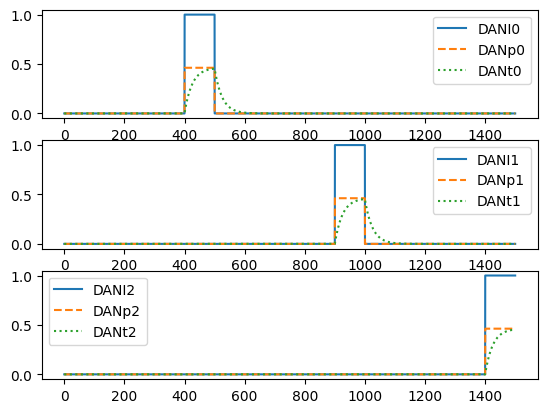

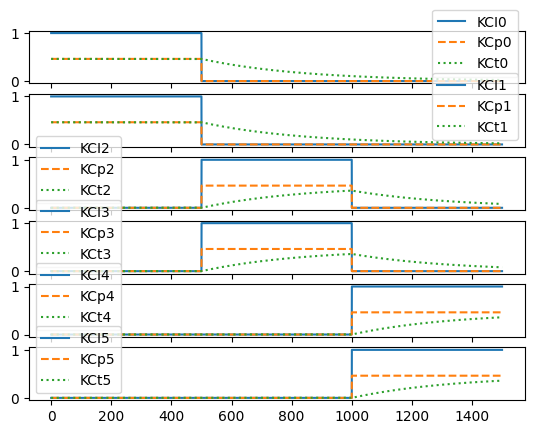

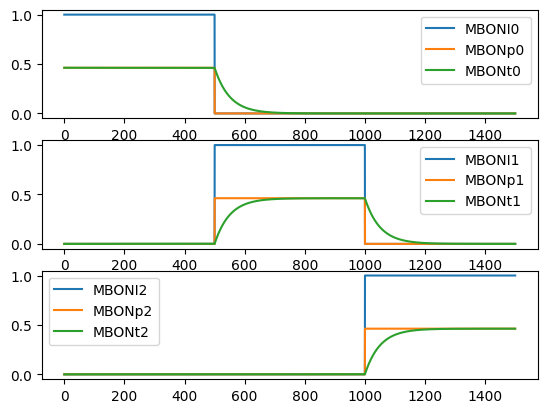

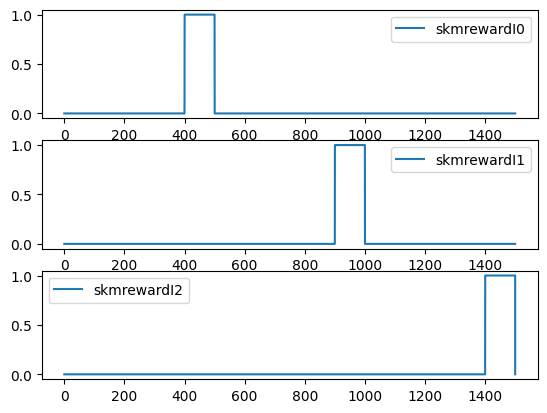

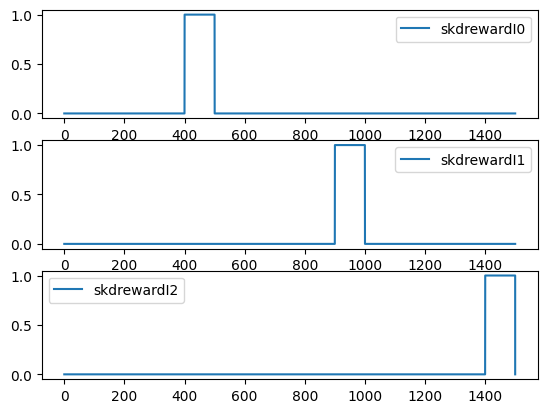

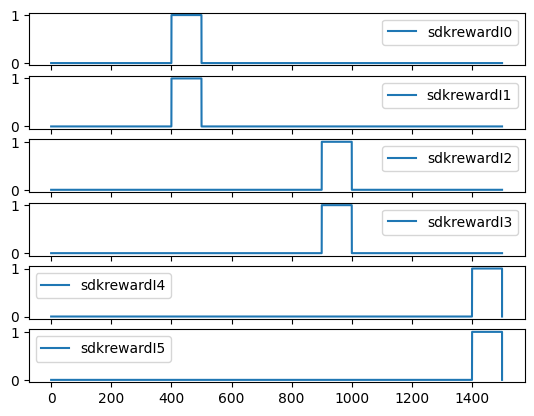

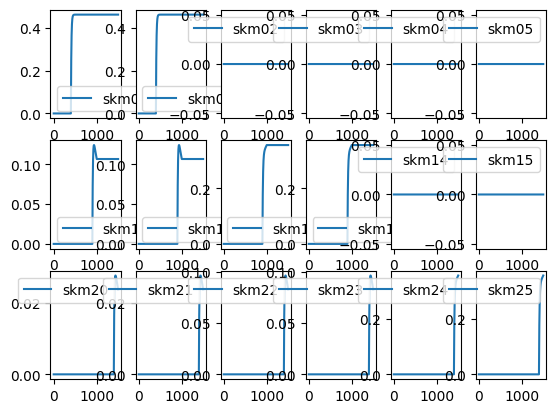

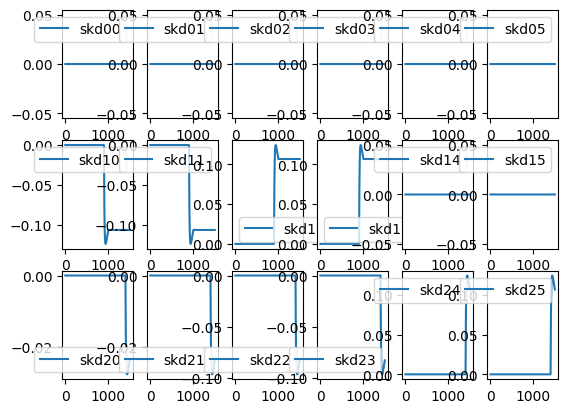

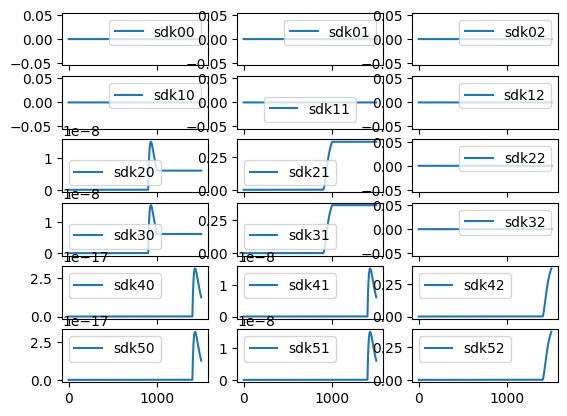

In [121]:
# 训练 一起画
# 初始权重,初始电流,初始化神经元、权重,初始化奖励
initWeightKM = np.zeros([numMBON,numKC])
initWeightKD = np.zeros([numDAN,numKC])
initWeightDK = np.zeros([numKC,numDAN])

IKC = np.array([1,1,0,0,0,0], dtype=np.float64).reshape(numKC,1)
KC = Neuron(numKC, IKC, dt=dt,tau=0.003)
IMBON = np.array([1,0,0]).reshape(numMBON,1)
MBON = Neuron(numMBON, IMBON, dt=dt,tau=0.02)
IDAN = np.array([0,0,0]).reshape(numDAN,1)
DAN = Neuron(numDAN,IDAN,dt=dt,tau=0.02)

# TODO: skm的奖励，skd的奖励，sdk的奖励 skd先用skm的（维度一样）
skmreward = np.array([0,0,0]).reshape(numMBON,1)
skdreward = np.array([0,0,0]).reshape(numDAN,1)
sdkreward = np.array([0,0,0,0,0,0]).reshape(numKC,1)

tau = 5
skm = SynapseKM(KC, MBON, initWeightKM, skmreward, dt=dt, tau=tau)
skd = SynapseKD(KC, DAN, initWeightKD, skdreward, dt=dt, tau=tau)
sdk = SynapseDK(DAN, KC, initWeightDK, sdkreward, dt=dt, tau=tau)

skmweight, skdweight, sdkweight=[], [], []
KCp, KCt, DANp, DANt, MBONp, MBONt = [], [], [], [], [], []
KCI, DANI, MBONI = [], [], []
skmrewardI, skdrewardI, sdkrewardI = [], [], []
# DANactivateKCI, DANactivateKCItra = [], []
# DANLPF = LowPassFilter(current=IDANactivateKC)

lenterm = end/3
for i in t:
    if i < lenterm:
        IKC = np.array([1,1,0,0,0,0], dtype=np.float64).reshape(numKC,1)
        IMBON = np.array([1,0,0]).reshape(numMBON,1)
    elif lenterm <= i < lenterm * 2:
        IKC = np.array([0,0,1,1,0,0], dtype=np.float64).reshape(numKC,1)
        IMBON = np.array([0,1,0]).reshape(numMBON,1)
    else:
        IKC = np.array([0,0,0,0,1,1], dtype=np.float64).reshape(numKC,1)
        IMBON = np.array([0,0,1]).reshape(numMBON,1)
        
    if lenterm * .8 < i < lenterm:
        skmreward = np.array([1,0,0]).reshape(numMBON,1)
        skdreward = np.array([1,0,0]).reshape(numDAN,1)
        sdkreward = np.array([1,1,0,0,0,0]).reshape(numKC,1)
        IDAN = np.array([1,0,0]).reshape(numDAN,1)
        # IKC = np.array([1 - (i - lenterm * .8)/100,1 - (i - lenterm * .8)/100,(i - lenterm * .8)/100,(i - lenterm * .8)/100,0,0]).reshape(numKC,1)
    elif lenterm * 1.8 < i < lenterm * 2:
        skmreward = np.array([0,1,0]).reshape(numMBON,1)
        skdreward = np.array([0,1,0]).reshape(numDAN,1)
        sdkreward = np.array([0,0,1,1,0,0]).reshape(numKC,1)
        IDAN = np.array([0,1,0]).reshape(numDAN,1)
        # IKC = np.array([0,0,1 - (i - lenterm * 1.8)/100,1 - (i - lenterm * 1.8)/100,(i - lenterm * 1.8)/100,(i - lenterm * 1.8)/100]).reshape(numKC,1)
    elif lenterm * 2.8 < i < lenterm * 3:
        skmreward = np.array([0,0,1]).reshape(numMBON,1)  
        skdreward = np.array([0,0,1]).reshape(numDAN,1) 
        sdkreward = np.array([0,0,0,0,1,1]).reshape(numKC,1)      
        IDAN = np.array([0,0,1]).reshape(numDAN,1)
        # IKC = np.array([(i - lenterm * 2.8)/100,(i - lenterm * 2.8)/100,0,0,1 - (i - lenterm * 2.8)/100,1 - (i - lenterm * 2.8)/100]).reshape(numKC,1)
    else:
        skmreward = np.array([0,0,0]).reshape(numMBON,1)
        skdreward = np.array([0,0,0]).reshape(numDAN,1)
        sdkreward = np.array([0,0,0,0,0,0]).reshape(numKC,1)
        IDAN = np.array([0,0,0]).reshape(numDAN,1)
          
    # IDANactivateKC = np.matmul(WeightDK, IDAN)
    
    # DANactivateKCI.append(DANLPF.current)
    # IDANactivateKCtra = DANLPF.step(dt=dt, current=IDANactivateKC)
    # DANactivateKCItra.append(DANLPF.history)
    # DANLPF.update()
    # print(IKC.dtype,IDANactivateKCtra.dtype)
    # IKC += IDANactivateKCtra
    skm.reward = skmreward
    skd.reward = skdreward
    sdk.reward = sdkreward
    
    skmrewardI.append(skmreward)
    skdrewardI.append(skdreward)
    sdkrewardI.append(sdkreward)
    
    DANI.append(skd.postI)  # TODO:add potential, trajectory  
    DANp.append(skd.postPotential)
    DANt.append(skd.postTrajectory)

    KCI.append(skm.preI)
    KCp.append(skm.prePotential)
    KCt.append(skm.preTrajectory)
    
    MBONI.append(skm.postI)
    MBONp.append(skm.postPotential)
    MBONt.append(skm.postTrajectory)
    
    # print(skm.preTrajectory)
    KMWeight = skm.step(dt,IKC,IMBON)
    skm.update()
    skmweight.append(KMWeight)
    
    KDWeight = skd.step(dt,IKC,IDAN)
    skd.update()
    skdweight.append(KDWeight)

    DKWeight = sdk.step(dt,IDAN,IKC)
    sdk.update()
    sdkweight.append(DKWeight)



# 画DANI
DANI = np.array(DANI)
DANp = np.array(DANp)
DANt = np.array(DANt)
for i in range(numDAN):
    plt.subplot(numDAN,1,i+1)
    myplot(t, DANI[:,i,0], label='DANI'+str(i))
    myplot(t, DANp[:,i,0], label='DANp'+str(i),linestyle='--')
    myplot(t, DANt[:,i,0], label='DANt'+str(i),linestyle=':')
plt.show()

# 画danpotential
# DANactivateKCI = np.array(DANactivateKCI)
# DANactivateKCItra = np.array(DANactivateKCItra)
# for i in range(numKC):
#     plt.subplot(numKC,1,i+1)
#     myplot(t,DANactivateKCI[:,i,0], label='DANpKCI'+str(i))
#     myplot(t,DANactivateKCItra[:,i,0], label='DANpKCIt'+str(i))
# plt.show()

# linstylelist = ['-',':','-.','--']
# plt.figure()
# 画KC
KCI = np.array(KCI)
KCp = np.array(KCp)
KCt = np.array(KCt)
# KCt = relu(KCt,reluoffset)
for i in range(numKC):
    plt.subplot(numKC,1,i+1)
    myplot(t,KCI[:,i,0],label='KCI'+str(i),)
    myplot(t,KCp[:,i,0],label='KCp'+str(i),linestyle='--')
    myplot(t,KCt[:,i,0],label='KCt'+str(i),linestyle=':')
plt.show()

# # 画MBON
MBONI = np.array(MBONI)
MBONp = np.array(MBONp)
MBONt = np.array(MBONt)
for i in range(numMBON):
    plt.subplot(numMBON,1,i+1)
    myplot(t,MBONI[:,i,0],label='MBONI'+str(i)) 
    myplot(t,MBONp[:,i,0],label='MBONp'+str(i))   
    myplot(t,MBONt[:,i,0],label='MBONt'+str(i))   
plt.show() 

# # 画reward
skmrewardI = np.array(skmrewardI)
for i in range(numMBON):
    plt.subplot(numMBON,1,i+1)
    myplot(t, skmrewardI[:,i,0], label='skmrewardI'+str(i))
plt.show()

skdrewardI = np.array(skdrewardI)
for i in range(numDAN):
    plt.subplot(numDAN,1,i+1)
    myplot(t, skdrewardI[:,i,0], label='skdrewardI'+str(i))
plt.show()

sdkrewardI = np.array(sdkrewardI)
for i in range(numKC):
    plt.subplot(numKC,1,i+1)
    myplot(t, sdkrewardI[:,i,0], label='sdkrewardI'+str(i))
plt.show()

# 画权重
# 完成skm
skmweight = np.array(skmweight)
ylimlow, ylimhigh = 0, .5

# cur_figsize = plt.gcf().get_size_inches()
# plt.figure(figsize=(cur_figsize[0] * 3, cur_figsize[1] * 1.5))
for j in range(numMBON):
    for i in range(numKC):
        plt.subplot(numMBON,numKC,j*numKC+i+1)     
        myplot(t,skmweight[:,j,i],label='skm'+str(j)+str(i))
plt.show()
    
# TODO:完成skd
skdweight = np.array(skdweight)
for j in range(numDAN):
    for i in range(numKC):
        plt.subplot(numDAN,numKC,j*numKC+i+1)
        # plt.ylim(ylimlow,ylimhigh)
        myplot(t,skdweight[:,j,i],label='skd'+str(j)+str(i))
plt.show()

# TODO:完成sdk
sdkweight = np.array(sdkweight)
for j in range(numKC):
    for i in range(numDAN):
        plt.subplot(numKC,numDAN,j*numDAN+i+1)
        # plt.ylim(ylimlow,ylimhigh)
        myplot(t,sdkweight[:,j,i],label='sdk'+str(j)+str(i))
plt.show()

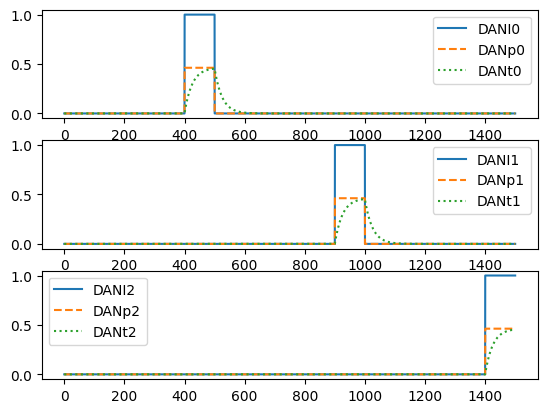

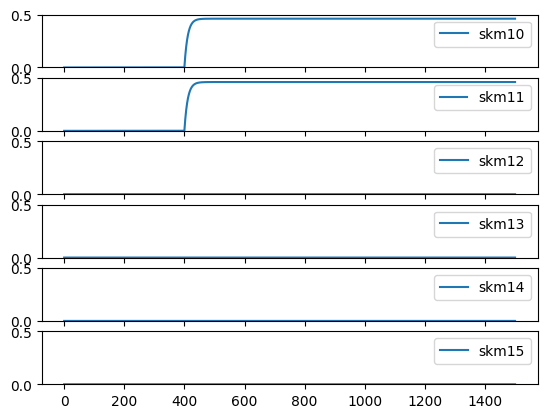

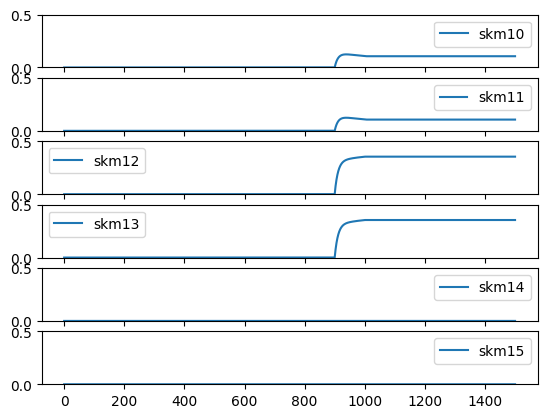

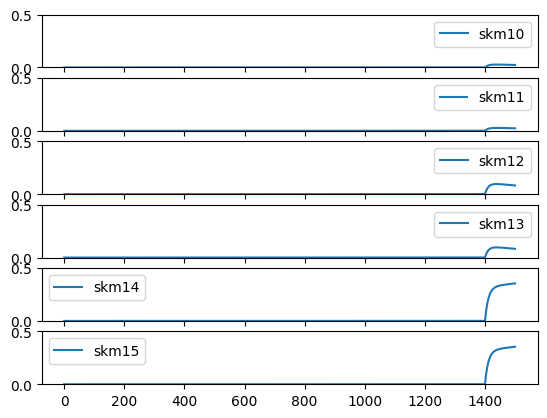

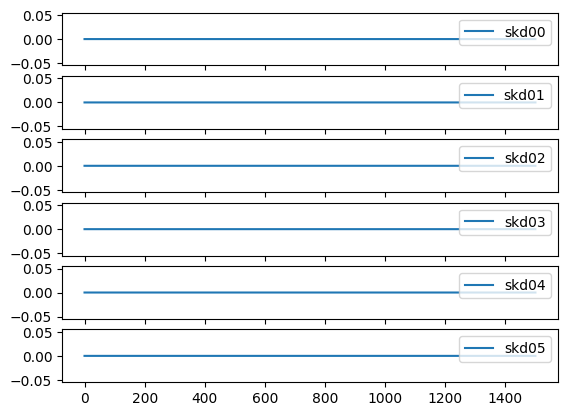

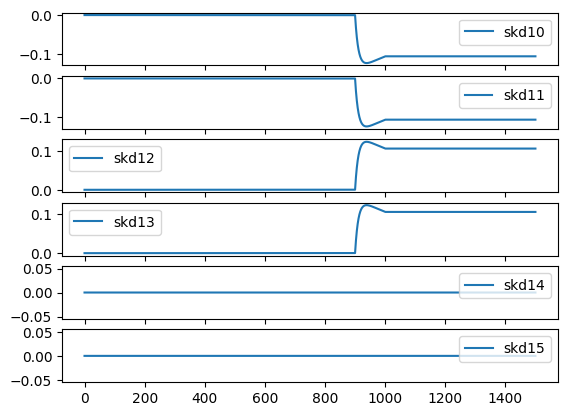

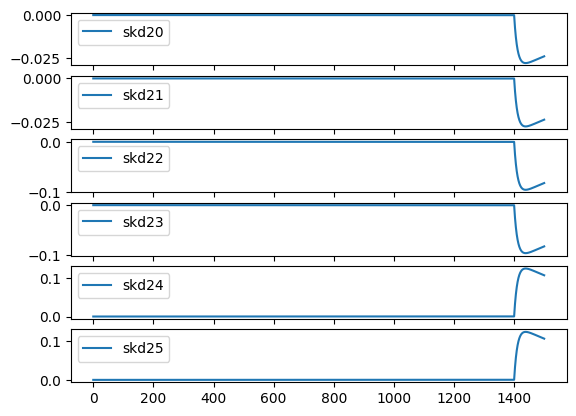

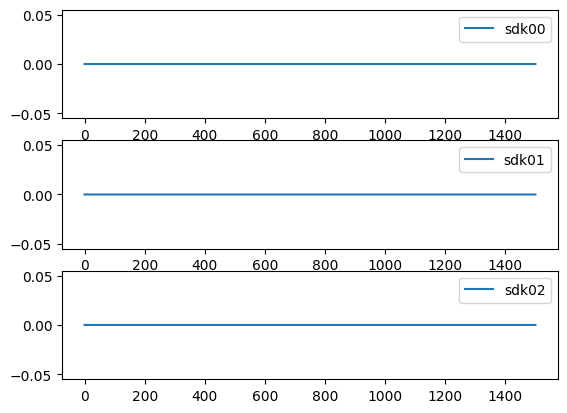

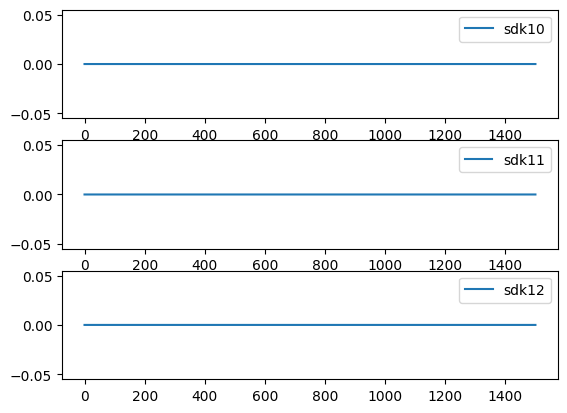

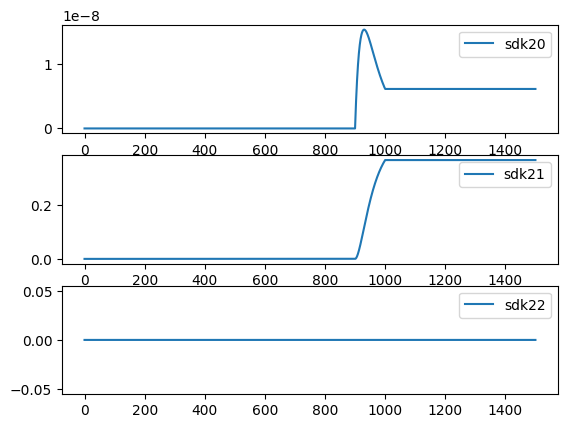

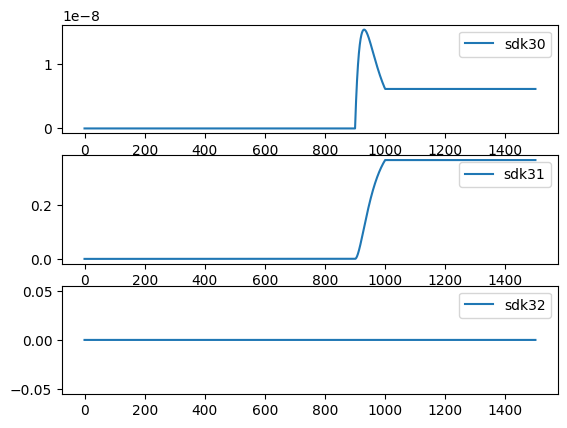

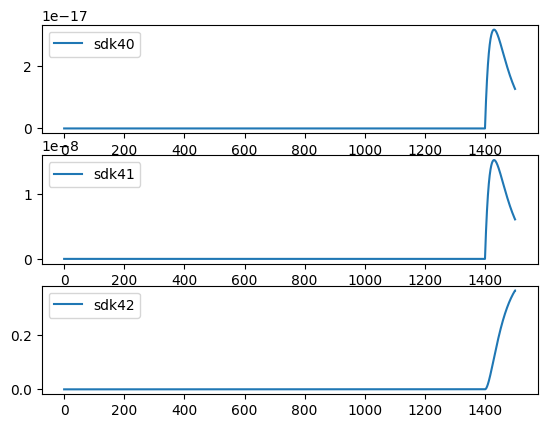

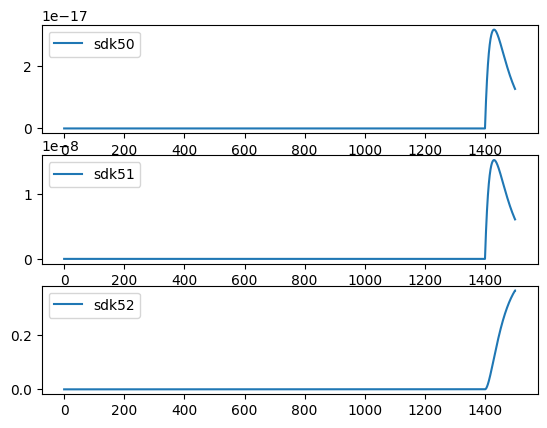

In [122]:
# 训练 分开画
# 初始权重,初始电流,初始化神经元、权重,初始化奖励
initWeightKM = np.zeros([numMBON,numKC])
initWeightKD = np.zeros([numDAN,numKC])
initWeightDK = np.zeros([numKC,numDAN])

IKC = np.array([1,1,0,0,0,0], dtype=np.float64).reshape(numKC,1)
KC = Neuron(numKC, IKC, dt=dt,tau=0.001)
IMBON = np.array([1,0,0]).reshape(numMBON,1)
MBON = Neuron(numMBON, IMBON, dt=dt,tau=0.02)
IDAN = np.array([0,0,0]).reshape(numDAN,1)
DAN = Neuron(numDAN,IDAN,dt=dt,tau=0.02)

# TODO: skm的奖励，skd的奖励，sdk的奖励 skd先用skm的（维度一样）
skmreward = np.array([0,0,0]).reshape(numMBON,1)
skdreward = np.array([0,0,0]).reshape(numDAN,1)
sdkreward = np.array([0,0,0,0,0,0]).reshape(numKC,1)

tau = 5
skm = SynapseKM(KC, MBON, initWeightKM, skmreward, dt=dt, tau=tau)
skd = SynapseKD(KC, DAN, initWeightKD, skdreward, dt=dt, tau=tau)
sdk = SynapseDK(DAN, KC, initWeightDK, sdkreward, dt=dt, tau=tau)

skmweight, skdweight, sdkweight=[], [], []
KCp, KCt, DANp, DANt, MBONp, MBONt = [], [], [], [], [], []
KCI, DANI, MBONI = [], [], []
skmrewardI, skdrewardI, sdkrewardI = [], [], []
# DANactivateKCI, DANactivateKCItra = [], []
# DANLPF = LowPassFilter(current=IDANactivateKC)

lenterm = end/3
for i in t:
    if i < lenterm:
        IKC = np.array([1,1,0,0,0,0], dtype=np.float64).reshape(numKC,1)
        IMBON = np.array([1,0,0]).reshape(numMBON,1)
    elif lenterm <= i < lenterm * 2:
        IKC = np.array([0,0,1,1,0,0], dtype=np.float64).reshape(numKC,1)
        IMBON = np.array([0,1,0]).reshape(numMBON,1)
    else:
        IKC = np.array([0,0,0,0,1,1], dtype=np.float64).reshape(numKC,1)
        IMBON = np.array([0,0,1]).reshape(numMBON,1)
        
    if lenterm * .8 < i < lenterm:
        skmreward = np.array([1,0,0]).reshape(numMBON,1)
        skdreward = np.array([1,0,0]).reshape(numDAN,1)
        sdkreward = np.array([1,1,0,0,0,0]).reshape(numKC,1)
        IDAN = np.array([1,0,0]).reshape(numDAN,1)
        # IKC = np.array([1 - (i - lenterm * .8)/100,1 - (i - lenterm * .8)/100,(i - lenterm * .8)/100,(i - lenterm * .8)/100,0,0]).reshape(numKC,1)
    elif lenterm * 1.8 < i < lenterm * 2:
        skmreward = np.array([0,1,0]).reshape(numMBON,1)
        skdreward = np.array([0,1,0]).reshape(numDAN,1)
        sdkreward = np.array([0,0,1,1,0,0]).reshape(numKC,1)
        IDAN = np.array([0,1,0]).reshape(numDAN,1)
        # IKC = np.array([0,0,1 - (i - lenterm * 1.8)/100,1 - (i - lenterm * 1.8)/100,(i - lenterm * 1.8)/100,(i - lenterm * 1.8)/100]).reshape(numKC,1)
    elif lenterm * 2.8 < i < lenterm * 3:
        skmreward = np.array([0,0,1]).reshape(numMBON,1)  
        skdreward = np.array([0,0,1]).reshape(numDAN,1) 
        sdkreward = np.array([0,0,0,0,1,1]).reshape(numKC,1)      
        IDAN = np.array([0,0,1]).reshape(numDAN,1)
        # IKC = np.array([(i - lenterm * 2.8)/100,(i - lenterm * 2.8)/100,0,0,1 - (i - lenterm * 2.8)/100,1 - (i - lenterm * 2.8)/100]).reshape(numKC,1)
    else:
        skmreward = np.array([0,0,0]).reshape(numMBON,1)
        skdreward = np.array([0,0,0]).reshape(numDAN,1)
        sdkreward = np.array([0,0,0,0,0,0]).reshape(numKC,1)
        IDAN = np.array([0,0,0]).reshape(numDAN,1)
          
    # IDANactivateKC = np.matmul(WeightDK, IDAN)
    
    # DANactivateKCI.append(DANLPF.current)
    # IDANactivateKCtra = DANLPF.step(dt=dt, current=IDANactivateKC)
    # DANactivateKCItra.append(DANLPF.history)
    # DANLPF.update()
    # print(IKC.dtype,IDANactivateKCtra.dtype)
    # IKC += IDANactivateKCtra
    skm.reward = skmreward
    skd.reward = skdreward
    sdk.reward = sdkreward
    
    skmrewardI.append(skmreward)
    skdrewardI.append(skdreward)
    sdkrewardI.append(sdkreward)
    
    DANI.append(skd.postI)  # TODO:add potential, trajectory  
    DANp.append(skd.postPotential)
    DANt.append(skd.postTrajectory)

    KCI.append(skm.preI)
    KCp.append(skm.prePotential)
    KCt.append(skm.preTrajectory)
    
    MBONI.append(skm.postI)
    MBONp.append(skm.postPotential)
    MBONt.append(skm.postTrajectory)
    
    # print(skm.preTrajectory)
    KMWeight = skm.step(dt,IKC,IMBON)
    skm.update()
    skmweight.append(KMWeight)
    
    KDWeight = skd.step(dt,IKC,IDAN)
    skd.update()
    skdweight.append(KDWeight)

    DKWeight = sdk.step(dt,IDAN,IKC)
    sdk.update()
    sdkweight.append(DKWeight)



# 画DANI
DANI = np.array(DANI)
DANp = np.array(DANp)
DANt = np.array(DANt)
for i in range(numDAN):
    plt.subplot(numDAN,1,i+1)
    myplot(t, DANI[:,i,0], label='DANI'+str(i))
    myplot(t, DANp[:,i,0], label='DANp'+str(i),linestyle='--')
    myplot(t, DANt[:,i,0], label='DANt'+str(i),linestyle=':')
plt.show()

# # 画danpotential
# # DANactivateKCI = np.array(DANactivateKCI)
# # DANactivateKCItra = np.array(DANactivateKCItra)
# # for i in range(numKC):
# #     plt.subplot(numKC,1,i+1)
# #     myplot(t,DANactivateKCI[:,i,0], label='DANpKCI'+str(i))
# #     myplot(t,DANactivateKCItra[:,i,0], label='DANpKCIt'+str(i))
# # plt.show()

# # linstylelist = ['-',':','-.','--']
# # plt.figure()
# # 画KC
# KCI = np.array(KCI)
# KCp = np.array(KCp)
# KCt = np.array(KCt)
# # KCt = relu(KCt,reluoffset)
# for i in range(numKC):
#     plt.subplot(numKC,1,i+1)
#     myplot(t,KCI[:,i,0],label='KCI'+str(i),)
#     myplot(t,KCp[:,i,0],label='KCp'+str(i),linestyle='--')
#     myplot(t,KCt[:,i,0],label='KCt'+str(i),linestyle=':')
# plt.show()

# # 画MBON
# MBONI = np.array(MBONI)
# MBONp = np.array(MBONp)
# MBONt = np.array(MBONt)
# for i in range(numMBON):
#     plt.subplot(numMBON,1,i+1)
#     myplot(t,MBONI[:,i,0],label='MBONI'+str(i)) 
#     myplot(t,MBONp[:,i,0],label='MBONp'+str(i))   
#     myplot(t,MBONt[:,i,0],label='MBONt'+str(i))   
# plt.show() 

# # 画reward
# skmrewardI = np.array(skmrewardI)
# for i in range(numMBON):
#     plt.subplot(numMBON,1,i+1)
#     myplot(t, skmrewardI[:,i,0], label='skmrewardI'+str(i))
# plt.show()

# skdrewardI = np.array(skdrewardI)
# for i in range(numDAN):
#     plt.subplot(numDAN,1,i+1)
#     myplot(t, skdrewardI[:,i,0], label='skdrewardI'+str(i))
# plt.show()

# sdkrewardI = np.array(sdkrewardI)
# for i in range(numKC):
#     plt.subplot(numKC,1,i+1)
#     myplot(t, sdkrewardI[:,i,0], label='sdkrewardI'+str(i))
# plt.show()

# 画权重
# 完成skm
skmweight = np.array(skmweight)
ylimlow, ylimhigh = 0, .5
"""

# cur_figsize = plt.gcf().get_size_inches()
# plt.figure(figsize=(cur_figsize[0] * 3, cur_figsize[1] * 1.5))
# for j in range(numMBON):
#     for i in range(numKC):
#         plt.subplot(numMBON,numKC,j*numKC+i+1)     
#         myplot(t,skmweight[:,j,i],label='skm'+str(j)+str(i))
# plt.show()


# skmweight = relu(skmweight,reluoffset)
# for i in range(numKC):
#     plt.subplot(numKC,1,i+1)
#     plt.ylim(ylimlow,ylimhigh)
#     myplot(t,skmweight[:,0,i],label='skm'+str(0)+str(i))
# plt.show()

# for i in range(numKC):
#     plt.subplot(numKC,1,i+1)
#     plt.ylim(ylimlow,ylimhigh)
#     myplot(t,skmweight[:,1,i],label='skm'+str(1)+str(i))
# plt.show()

# for i in range(numKC):
#     plt.subplot(numKC,1,i+1)
#     plt.ylim(ylimlow,ylimhigh)
#     myplot(t,skmweight[:,2,i],label='skm'+str(2)+str(i))
# plt.show()

"""
for j in range(numMBON):
    for i in range(numKC):
        plt.subplot(numKC,1,i+1)
        plt.ylim(ylimlow,ylimhigh)
        myplot(t,skmweight[:,j,i],label='skm'+str(1)+str(i))
    plt.show()
        
# TODO:完成skd
skdweight = np.array(skdweight)
for j in range(numDAN):
    for i in range(numKC):
        plt.subplot(numKC,1,i+1)
        # plt.ylim(ylimlow,ylimhigh)
        myplot(t,skdweight[:,j,i],label='skd'+str(j)+str(i))
    plt.show()

# TODO:完成sdk
sdkweight = np.array(sdkweight)
for j in range(numKC):
    for i in range(numDAN):
        plt.subplot(numDAN,1,i+1)
        # plt.ylim(ylimlow,ylimhigh)
        myplot(t,sdkweight[:,j,i],label='sdk'+str(j)+str(i))
    plt.show()

## 4.25

In [ ]:
# 